This notebook evalutes some of the perforamnce of our pipeline in pred_model_implementation. functions were written, performed, and analyzed below. This can be useful for our presenttation

### Downloading the model first

In [47]:
import os, certifi
os.environ["SSL_CERT_FILE"] = certifi.where()
os.environ["REQUESTS_CA_BUNDLE"] = certifi.where()

In [48]:
from sentence_transformers import SentenceTransformer
import tqdm as tqdm

model = SentenceTransformer("sentence-transformers/distiluse-base-multilingual-cased-v2")
print("Model loaded")

Model loaded


### Reading in data and making df

In [49]:
import numpy as np
import pandas as pd
from typing import List, Dict, Any

df1 = pd.read_parquet("lyric_embeddings/librosa_shard_0.parquet")
df2 = pd.read_parquet("lyric_embeddings/librosa_shard_1.parquet")
df3 = pd.read_parquet("lyric_embeddings/librosa_shard_2.parquet")
df4 = pd.read_parquet("lyric_embeddings/librosa_shard_3.parquet")
df5 = pd.read_parquet("lyric_embeddings/librosa_shard_4.parquet")

df = pd.concat([df1, df2, df3, df4, df5])

### REAL embedding functions

In [50]:
import faiss

emb_list = [np.asarray(x, dtype="float32") for x in df["lyrics_embedding"].values]
emb_matrix = np.stack(emb_list, axis=0)
dimension = emb_matrix.shape[1]   # e.g., 768
index = faiss.IndexFlatL2(dimension)

# Add embeddings to the index
index.add(emb_matrix.astype("float32"))

print("FAISS index built with", index.ntotal, "vectors.")

def retrieve_similar_songs(query_embedding: np.ndarray, k: int = 5) -> List[Dict[str, Any]]:
    # Ensure query is 2D array (1, 384) for FAISS
    query_vector = np.array([query_embedding]).astype('float32')

    # 1. Search the index
    # Note: We search the 'index' object we created in the previous cell
    D, I = index.search(query_vector, k)

    neighbors = []
    # I[0] contains the IDs, D[0] contains the distances
    for idx, dist in zip(I[0], D[0]):
        if idx != -1:
            neighbors.append({
                "index": int(idx),
                "similarity": float(dist) # In L2, lower is better.
            })

    return neighbors


FAISS index built with 20740 vectors.


In [51]:
import re
import unicodedata

# ---------- Cleaning helper for queries ----------

def clean_lyrics_for_query(text: str) -> str:
    """
    Simple lyric cleaner for user queries.

    • Lowercases text
    • Removes [chorus], [verse 1], etc.
    • Flattens newlines / \n into spaces
    • Strips things like (prod. xxx), (remix)
    • Drops repeat markers like x2, x3
    • Keeps letters (any language), digits, spaces, apostrophes
    """

    if not isinstance(text, str):
        return ""

    text = text.lower()

    # remove headers like [chorus], [verse 1], etc.
    text = re.sub(r"\[.*?\]", " ", text)

    # handle real and escaped newlines
    text = text.replace("\\n", " ").replace("\n", " ")

    # remove (prod. ...), (remix ...)
    text = re.sub(r"\(.*?prod.*?\)", " ", text)
    text = re.sub(r"\(.*?remix.*?\)", " ", text)

    # remove x2, x3, etc.
    text = re.sub(r"\bx\d+\b", " ", text)

    # keep letters (any language), numbers, spaces, apostrophes
    chars = []
    for ch in text:
        cat = unicodedata.category(ch)
        if cat.startswith("L") or cat.startswith("N") or ch in [" ", "'", "’"]:
            chars.append(ch)

    text = "".join(chars)

    # collapse multiple spaces
    text = re.sub(r"\s+", " ", text).strip()
    return text


# ---------- REAL embedding function ----------

def embed_lyrics(text: str) -> np.ndarray:
    cleaned = clean_lyrics_for_query(text)

    # Encode returns a list of vectors when input is a list
    emb = model.encode(
        [cleaned],                    # IMPORTANT: wrap in list
        convert_to_numpy=True,
        normalize_embeddings=True
    )

    # emb has shape (1, D) → extract row 0
    vec = emb[0]

    # Ensure float32 1D
    vec = np.asarray(vec, dtype="float32").reshape(-1)

    return vec



In [52]:
audio_feature_cols = df.columns[df.columns.get_loc("duration") : df.columns.get_loc("tonnetz_6") + 1].tolist()
df.head()

,song_id,title,artist,query_title,query_artist,track_genre,popularity,lyrics,preview_url,track_id,...,spectral_contrast_6,spectral_contrast_7,tonnetz_1,tonnetz_2,tonnetz_3,tonnetz_4,tonnetz_5,tonnetz_6,lyrics_clean,lyrics_embedding
0,4845,State of Mind,Scooter,state of mind,scooter,happy,24.0,The world seems not the same...\n\nIntroducing...,https://audio-ssl.itunes.apple.com/itunes-asse...,1692327616,...,18.328021,39.053367,0.197966,-0.116721,0.142559,-0.069539,-0.044986,-0.047523,the world seems not the same introducing twist...,"[0.07519827783107758, -0.023364899680018425, -..."
1,462,Reptilia,The Strokes,reptilia,the strokes,alt-rock,75.0,[Verse 1]\nHe seemed impressed by the way you ...,https://audio-ssl.itunes.apple.com/itunes-asse...,302987569,...,17.382681,39.012014,0.078138,-0.077754,0.063345,0.036541,-0.011976,-0.014041,he seemed impressed by the way you came in tel...,"[-0.08670999109745026, -0.025700576603412628, ..."
2,16017,None Of My Business,Cher Lloyd,none of my business,cher lloyd,electro,64.0,"[Chorus]\nDamn, I heard that you and her been ...",https://audio-ssl.itunes.apple.com/itunes-asse...,1438630505,...,18.248683,39.966514,0.013912,0.172900,-0.092766,-0.056323,-0.004173,-0.014388,damn i heard that you and her been having prob...,"[0.01792941242456436, 0.001567921251989901, 0...."
3,9478,Trouble Sleeping,The Perishers,trouble sleeping,the perishers,acoustic,48.0,I'm having trouble sleeping\nYou're jumping in...,https://audio-ssl.itunes.apple.com/itunes-asse...,89335271,...,16.969837,28.947224,-0.118755,0.195544,0.025169,-0.130705,0.024176,0.005865,i'm having trouble sleeping you're jumping in ...,"[0.012034112587571144, -0.0008498362149111927,..."
4,2822,Shot in the Dark,Ozzy Osbourne,shot in the dark,ozzy osbourne,hard-rock,65.0,[Verse 1]\nOut on the streets I'm stalking the...,https://audio-ssl.itunes.apple.com/itunes-asse...,158711416,...,17.184653,35.540522,-0.113671,0.023209,-0.029743,-0.051142,0.003486,-0.011837,out on the streets i'm stalking the night i ca...,"[-0.05440174415707588, 0.0212415661662817, -0...."


In [53]:
def construct_feature_vector(
    target_embedding: np.ndarray,
    neighbors: List[Dict[str, Any]],
    audio_feature_cols: List[str],
    k: int = 3
) -> np.ndarray:

    vec = []

    target_embedding = np.asarray(target_embedding, dtype="float32").reshape(-1)
    EMB_DIM = target_embedding.shape[0]
    vec.extend(target_embedding.tolist())

    AUDIO_DIM = len(audio_feature_cols)
    NEIGHBOR_BLOCK = EMB_DIM + 2 + AUDIO_DIM  # emb + similarity + popularity + audio to ensure they all the same size

    for i in range(k):
        if i < len(neighbors):
            nb = neighbors[i]

            # neighbor embedding
            nb_emb = df.iloc[nb["index"]]["lyrics_embedding"]
            nb_emb = np.asarray(nb_emb, dtype="float32").reshape(-1)

            # fill nans if neighbros dont exist
            if nb_emb.shape[0] != EMB_DIM:
                fixed_emb = np.full(EMB_DIM, np.nan, dtype="float32")
                fixed_emb[:min(EMB_DIM, len(nb_emb))] = nb_emb[:EMB_DIM]
                nb_emb = fixed_emb

            vec.extend(nb_emb.tolist())

            # similarity
            sim = nb.get("similarity", np.nan)
            vec.append(float(sim))

            # popularity
            vec.append(float(nb["popularity"]))

            # audio features
            af = nb["audio_features"]
            for col in audio_feature_cols:
                val = af.get(col, np.nan)
                if isinstance(val, (float, int, np.floating)):
                    vec.append(float(val))
                else:
                    vec.append(np.nan)

        else:
            vec.extend([np.nan] * NEIGHBOR_BLOCK)

    return np.asarray(vec, dtype="float32")


In [54]:
def get_top_k_neighbors(df, query_embedding, k=5):
    raw_neighbors = retrieve_similar_songs(query_embedding, k=k)
    neighbors = []

    for n in raw_neighbors:
        idx = n["index"]
        row = df.iloc[idx]

        audio_features = {}

        for col in audio_feature_cols:
            val = row[col]

            # keep if scalar
            if np.isscalar(val):
                audio_features[col] = float(val)
            
            # flatten if array
            elif isinstance(val, np.ndarray):
                val = val.flatten()
                for j, v in enumerate(val):
                    audio_features[f"{col}_{j}"] = float(v)
            
            # flatten if list
            elif isinstance(val, list):
                for j, v in enumerate(val):
                    audio_features[f"{col}_{j}"] = float(v)

            else:
                try:
                    audio_features[col] = float(val)
                except Exception:
                    audio_features[col] = None

        neighbor_data = {
            "index": idx,
            "song_id": row["song_id"],
            "title": row["title"],
            "artist": row["artist"],
            "similarity": n.get("similarity", None),
            "popularity": float(row["popularity"]),
            "lyrics_snippet": row["lyrics"][:400].replace("\n", " ") + "...",
            "audio_features": audio_features
        }
        
        neighbors.append(neighbor_data)

    return neighbors


The function below evaluates our FAISS method for similary search. it rnadomly samples 'num_samples' songs to measure:

- average recall@5: whether retrieved neighbors share the same genre as the target song

- average absolute difference in popularity between a song and its retrieved neighbors

- average FAISS L2 distance between each song and its nearest neighbor

- average L2 distance between a lyric embedding and a random unrelated song

- and the ratio between distance from a random song over top1 distance
	​




In [25]:
### --- SIMILARITY SEARCH EVALUATION METRICS ---
from sklearn.metrics.pairwise import cosine_similarity

def evaluate_similarity_search(df, k=5, num_samples=300):
    """
    Evaluate retrieval quality using:
      - Genre recall@k
      - Popularity distance
      - FAISS distance diagnostics
    Self-matches are removed so top1 distance is meaningful.
    """

    rng = np.random.default_rng(42)
    sample_indices = rng.choice(len(df), size=num_samples, replace=False)

    recall_scores = []
    pop_distances = []
    top1_distances = []
    random_distances = []

    for idx in sample_indices:
        row = df.iloc[idx]
        emb = np.asarray(row["lyrics_embedding"], dtype="float32")
        genre = row["track_genre"]
        pop = row["popularity"]

        # Retrieve neighbors while excluding the track itself
        raw = retrieve_similar_songs(emb, k=k+1)   # get extra
        neighbors = []

        for nb in raw:
            if nb["index"] != idx:   # remove self-match
                neighbors.append(nb)
            if len(neighbors) == k:
                break

        # Safety check in case retrieval gives fewer than k neighbors
        if len(neighbors) == 0:
            continue

        # ---------- 1. Genre Recall ----------
        same_genre = [
            1 if df.iloc[nb["index"]]["track_genre"] == genre else 0
            for nb in neighbors
        ]
        recall_scores.append(sum(same_genre) / k)

        # ---------- 2. Popularity Distance ----------
        pop_diff = np.mean([abs(df.iloc[nb["index"]]["popularity"] - pop)
                            for nb in neighbors])
        pop_distances.append(pop_diff)

        # ---------- 3. Top-1 FAISS Distance ----------
        top1_distances.append(neighbors[0]["similarity"])

        # ---------- 4. Random Negative Distance ----------
        rand_idx = rng.choice(len(df))
        rand_emb = np.asarray(df.iloc[rand_idx]["lyrics_embedding"], dtype="float32")
        d_rand = float(np.linalg.norm(emb - rand_emb))
        random_distances.append(d_rand)

    return {
        "genre_recall_mean": np.mean(recall_scores),
        "pop_distance_mean": np.mean(pop_distances),
        "top1_dist_mean": np.mean(top1_distances),
        "random_dist_mean": np.mean(random_distances),
        "top1_vs_random_ratio": np.mean(random_distances) / np.mean(top1_distances),
    }


# run it
sim_eval = evaluate_similarity_search(df, k=5)
print(sim_eval)


{'genre_recall_mean': 0.07200000000000001, 'pop_distance_mean': 21.936, 'top1_dist_mean': 0.6875483393661367, 'random_dist_mean': 1.1651294269164403, 'top1_vs_random_ratio': 1.6946145604694418}


The similarity-search evaluation reveals that our lyric-based FAISS retrieval is primarily capturing semantic textual similarity rather than musical similarity. The Genre Recall@5 score of 0.072 indicates that only  about 7% of retrieved neighbors share the same genre as the target song, which means that the sentence-transformer embeddings emphasize lyrical meaning rather than audio driven genre distinctions. The average popularity distance of 21.9 unfortunately suggests that lyrical similarity does not strongly correlate with popularity, reinforcing that popularity is influenced by many non-lyrical factors. Importantly, the FAISS distance metrics show meaningful retrieval behavior: the average nearest-neighbor distance (0.688) is substantially smaller than the average random-pair distance (1.165), producing a top-1 vs random ratio of 1.69, confirming that the embedding space is structured enough for reliable neighbor retrieval. Overall, these results validate that the retrieval component of our RAG pipeline finds semantically similar lyric neighbors rather than genre- or popularity-matched songs, which aligns with our goal of providing lyrically grounded contextual evidence for downstream popularity explanations.

In [55]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def compute_semantic_coherence(df, k=3, num_samples=200):
    """
    Measures whether FAISS neighbors are more semantically similar 
    to the query lyric than random songs.
    """

    rng = np.random.default_rng(0)
    sample_indices = rng.choice(len(df), size=num_samples, replace=False)

    neighbor_sims = []
    random_sims = []

    for idx in sample_indices:
        row = df.iloc[idx]
        query_emb = np.asarray(row["lyrics_embedding"], dtype="float32").reshape(1, -1)

        # Retrieve neighbors
        neighbors = get_top_k_neighbors(df, query_emb.flatten(), k=k)
        
        # Compute similarity to neighbors
        for nb in neighbors:
            emb_nb = np.asarray(df.iloc[nb["index"]]["lyrics_embedding"], dtype="float32").reshape(1, -1)
            sim = cosine_similarity(query_emb, emb_nb)[0][0]
            neighbor_sims.append(sim)

        # Random comparison
        rand_idx = rng.choice(len(df))
        rand_emb = np.asarray(df.iloc[rand_idx]["lyrics_embedding"], dtype="float32").reshape(1, -1)
        random_sims.append(cosine_similarity(query_emb, rand_emb)[0][0])

    return {
        "mean_neighbor_similarity": float(np.mean(neighbor_sims)),
        "mean_random_similarity": float(np.mean(random_sims)),
        "semantic_coherence_score": float(np.mean(neighbor_sims) / np.mean(random_sims))
    }
print(compute_semantic_coherence(df))

{'mean_neighbor_similarity': 0.7681275606155396, 'mean_random_similarity': 0.315833181142807, 'semantic_coherence_score': 2.432067394256592}


In [44]:
def compute_audio_alignment(df, audio_feature_cols, k=3, num_samples=200):
    """
    Compares audio feature distances between query->neighbors and query->random tracks.
    Lower distance to neighbors indicates better multimodal retrieval alignment.
    """

    rng = np.random.default_rng(0)
    sample_indices = rng.choice(len(df), size=num_samples, replace=False)

    neighbor_dists = []
    random_dists = []

    for idx in sample_indices:
        row = df.iloc[idx]
        query_audio = np.asarray(row[audio_feature_cols], dtype="float32")

        # Retrieve neighbors
        neighbors = get_top_k_neighbors(df, row["lyrics_embedding"], k=k)

        # Compute neighbor distances
        for nb in neighbors:
            nb_audio = np.asarray(df.iloc[nb["index"]][audio_feature_cols], dtype="float32")
            dist = np.linalg.norm(query_audio - nb_audio)
            neighbor_dists.append(dist)

        # Random comparison
        rand_idx = rng.choice(len(df))
        rand_audio = np.asarray(df.iloc[rand_idx][audio_feature_cols], dtype="float32")
        random_dists.append(np.linalg.norm(query_audio - rand_audio))

    return {
        "mean_neighbor_audio_distance": float(np.mean(neighbor_dists)),
        "mean_random_audio_distance": float(np.mean(random_dists)),
        "audio_alignment_score": float(np.mean(random_dists) / np.mean(neighbor_dists))
    }
print(compute_audio_alignment(df, audio_feature_cols))

{'mean_neighbor_audio_distance': 1542.5098876953125, 'mean_random_audio_distance': 2454.44873046875, 'audio_alignment_score': 1.5912045240402222}


The semantic coherence function compares the cosine similarity between a query lyric and its retrieved neighbors to the similarity between the same query and randomly sampled lyrics. This measures whether FAISS retrieval is capturing real semantic structure rather than random associations. 2.43 shows that neighbors are more than twice as semantically similar as random songs, indicating that lyric-based retrieval is working extremely well for our RAG pipeline. The audio alignment function computes the distance between a query’s audio features and those of its retrieved neighbors, then compares this distance to random audio pairs. This tests whether lyrics-based retrieval unintentionally preserves meaningful audio similarity—a desirable property for multimodal prediction. 1.59 shows that neighbors are substantially more audio-similar than random songs, suggesting that the retrieval stage benefits the multimodal nature of our popularity model.

In [56]:
X = []
y = []

for i, row in df.iterrows():
    target_lyric = row["lyrics"]
    target_embedding = np.asarray(row["lyrics_embedding"], dtype="float32")

    neighbors = get_top_k_neighbors(df, target_embedding, k=3)

    x_vec = construct_feature_vector(target_embedding, neighbors, audio_feature_cols, k=3)

    X.append(x_vec)
    y.append(row["popularity"])

X = np.vstack(X)
y = np.array(y, dtype="float32")


In [27]:
import lightgbm as lgb

train_data = lgb.Dataset(X, label=y)

params = {
    "objective": "regression",
    "metric": ["rmse", "mae"],
    "learning_rate": 0.05,
    "num_leaves": 63,
    "max_depth": -1,
    "feature_fraction": 0.9,
    "bagging_fraction": 0.8,
    "bagging_freq": 5,
}

model_lgb = lgb.train(params, train_data, num_boost_round=500)

print("LightGBM model trained!")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.213516 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 584457
[LightGBM] [Info] Number of data points in the train set: 20740, number of used features: 2299
[LightGBM] [Info] Start training from score 38.835680
LightGBM model trained!


In [57]:
import shap

explainer = shap.TreeExplainer(model_lgb)
shap_values = explainer.shap_values(x_vec.reshape(1, -1))

def summarize_shap_for_sample(
    shap_values: np.ndarray,
    feature_names: List[str] = None,
    top_n: int = 15
) -> List[Dict[str, Any]]:

    if shap_values.ndim == 2:
        shap_vals = shap_values[0]
    else:
        shap_vals = shap_values

    abs_vals = np.abs(shap_vals)
    top_idx = np.argsort(abs_vals)[::-1][:top_n]

    if feature_names is None:
        feature_names = [f"feature_{i}" for i in range(len(shap_vals))]

    summary = []
    for idx in top_idx:
        summary.append({
            "feature": feature_names[idx],
            "shap_value": float(shap_vals[idx])
        })
    return summary


def group_shap_fully(
    shap_vals: np.ndarray,
    EMB_DIM: int,
    audio_feature_cols: List[str],
    k_neighbors: int = 3
):

    if shap_vals.ndim == 2:
        shap_vals = shap_vals[0]

    idx = 0
    groups = {}

    AUDIO_DIM = len(audio_feature_cols)

    target_emb_shap = shap_vals[idx : idx + EMB_DIM]
    groups["target_embedding"] = float(np.sum(target_emb_shap))
    idx += EMB_DIM

    groups["neighbors"] = []

    for nb in range(k_neighbors):

        # group by embeddings
        emb_block = shap_vals[idx : idx + EMB_DIM]
        emb_sum = float(np.sum(emb_block))
        idx += EMB_DIM

        # group by similarity
        sim_shap = float(shap_vals[idx])
        idx += 1

        # group by popularity
        pop_shap = float(shap_vals[idx])
        idx += 1

        # dont group by audio features
        audio_block = shap_vals[idx : idx + AUDIO_DIM]
        idx += AUDIO_DIM
        
        audio_dict = {
            feature_name: float(audio_block[j])
            for j, feature_name in enumerate(audio_feature_cols)
        }

        groups["neighbors"].append({
            "embedding": emb_sum,
            "similarity": sim_shap,
            "popularity": pop_shap,
            "audio_features": audio_dict
        })

    return groups




In [29]:
# continue working on promping
def build_rag_prompt_for_lyric_popularity(
    user_lyric: str,
    neighbors: List[Dict[str, Any]],
    predicted_popularity: float,
    shap_summary: List[Dict[str, Any]]
):


    lines = []
    lines.append("You are an expert in music analytics, audio features, and lyric interpretation.")
    lines.append("Your task is to EXPLAIN a predicted popularity score for a NEW lyric.")
    lines.append("")
    lines.append("CRITICAL INSTRUCTIONS:")
    lines.append(" - DO NOT provide disclaimers about limitations of predicting popularity from lyrics.")
    lines.append(" - Ground every part of your explanation in the retrieved similar songs.")
    lines.append(" - Quote specific phrases from the neighbor lyrics when helpful.")
    lines.append(" - Explain audio features in simple, everyday terms.")
    lines.append(" - Use the SHAP feature-attribution summary as evidence for WHY the model made its prediction.")
    lines.append(" - Structure your explanation into multiple paragraphs:")
    lines.append("      Paragraph 1: Lyric similarity analysis using retrieved neighbors.")
    lines.append("      Paragraph 2: Audio feature comparisons (brightness, timbre, tempo, etc.).")
    lines.append("      Paragraph 3: Interpretation of SHAP results for this specific lyric.")
    lines.append("      Paragraph 4: Final justification tying all evidence together.")
    lines.append("")
    lines.append("Return ONLY valid JSON with this format:")
    lines.append("{")
    lines.append('  "predicted_popularity": <number>,')
    lines.append('  "explanation": "<multi-paragraph explanation grounded in evidence>"')
    lines.append("}")
    lines.append("")
    lines.append("IMPORTANT:")
    lines.append("Return ONLY raw JSON.")
    lines.append("Do NOT include any code fences such as ``` json")
    lines.append("Do NOT include any explanation text outside the JSON.")
    lines.append("Do NOT add commentary before or after the JSON.")
    lines.append("Return JSON ONLY.")
    lines.append("")
    lines.append("------------------------------------------------------------")
    lines.append("NEW LYRIC:")
    lines.append(user_lyric.strip())
    lines.append("------------------------------------------------------------")
    lines.append("")
    lines.append(f"Predicted Popularity Score: {predicted_popularity:.2f}")
    lines.append("")
    lines.append("------------------------------------------------------------")
    lines.append("SHAP FEATURE-ATTRIBUTION SUMMARY (TOP CONTRIBUTORS):")
    lines.append("These features influenced the model's prediction and should be used in the explanation:")
    lines.append("SHAP FEATURE ATTRIBUTION SUMMARY (GROUPED):")
    lines.append(f"  Target embedding contribution: {shap_summary['target_embedding']:+.3f}")

    lines.append("\nNeighbor Contributions:")
    for i, nb in enumerate(shap_summary["neighbors"], start=1):
        lines.append(f"  Neighbor {i}:")
        lines.append(f"    embedding: {nb['embedding']:+.3f}")
        lines.append(f"    similarity: {nb['similarity']:+.3f}")
        lines.append(f"    popularity: {nb['popularity']:+.3f}")
        lines.append("    audio_features:")
        for feat_name, val in nb["audio_features"].items():
            lines.append(f"      {feat_name}: {val:+.3f}")

    lines.append("------------------------------------------------------------")
    lines.append("")
    lines.append("SIMILAR SONGS RETRIEVED FROM THE DATASET:")
    lines.append("Use these songs as evidence for lyrical themes, audio patterns, and overall justification.")

    for i, nb in enumerate(neighbors, start=1):
        lines.append(f"\nNeighbor #{i}:")
        lines.append(f"  song_id: {nb['song_id']}")
        lines.append(f"  title: {nb['title']}")
        lines.append(f"  artist: {nb['artist']}")
        if nb.get("similarity") is not None:
            lines.append(f"  similarity_score: {nb['similarity']:.4f}  (lower = more similar lyrics)")
        lines.append(f"  popularity: {nb['popularity']:.2f}")
        lines.append(f"  lyrics_snippet: {nb['lyrics_snippet']}")
        lines.append("  audio_features:")
        for feat_name, feat_val in nb["audio_features"].items():
            # print with 4-decimal formatting if numeric
            if isinstance(feat_val, (int, float)):
                lines.append(f"    {feat_name}: {feat_val:.4f}")
            else:
                lines.append(f"    {feat_name}: {feat_val}")

    lines.append("")
    lines.append("------------------------------------------------------------")
    lines.append(
        "Using ONLY the information above — the new lyric, retrieved neighbors, "
        "the predicted popularity score, and the SHAP feature-attribution summary — "
        "produce a multi-paragraph explanation grounded in the dataset evidence. "
        "Do not speculate beyond what is shown. Do not include disclaimers. "
        "Focus on clear, real-world intuition about audio features, lyrical patterns, "
        "genre cues, and model attribution."
    )

    return "\n".join(lines)



In [30]:
import os
import re
import json
from openai import OpenAI
from dotenv import load_dotenv

load_dotenv()
client = OpenAI()

def call_llm_for_popularity_and_explanation(prompt: str) -> dict:

    response = client.responses.create(
        model="gpt-4o",
        input=prompt,
        temperature=0.2,
        max_output_tokens=900
    )

    raw_text = response.output[0].content[0].text.strip()

    # Remove any ```json ...``` or ```
    raw_text = raw_text.replace("```json", "")
    raw_text = raw_text.replace("```", "")
    raw_text = raw_text.strip()

    # first try direct json parse
    try:
        return json.loads(raw_text)
    except:
        pass

    # else, find outside json block using regex
    json_matches = re.findall(r"\{(?:[^{}]|(?:\{[^{}]*\}))*\}", raw_text, flags=re.DOTALL)

    if json_matches:
        for match in json_matches:
            try:
                return json.loads(match)
            except:
                continue

    # try to repair json with trailing commas
    repaired = re.sub(r",\s*([}\]])", r"\1", raw_text)

    try:
        return json.loads(repaired)
    except:
        pass

    # else, say failed
    print("Could not parse JSON from LLM output. Returning raw text.")
    return {
        "predicted_popularity": None,
        "explanation": raw_text
    }





In [31]:
def rag_lyric_popularity_system(
    df: pd.DataFrame,
    user_lyric: str,
    k_neighbors: int = 3,
    top_shap_features: int = 15,
    feature_names: List[str] = None
) -> Dict[str, Any]:
    """
    Full pipeline:
      1) Embed new lyric
      2) Retrieve top-k similar songs
      3) Build multimodal feature vector
      4) Predict popularity with LightGBM
      5) Get TreeSHAP local explanation
      6) Build RAG prompt and call LLM for explanation
    """

    # 1) embed target lyric
    query_embedding = embed_lyrics(user_lyric)

    # 2) retrieve neighbors using FAISS + your helper
    neighbors = get_top_k_neighbors(df, query_embedding, k=k_neighbors)

    # 3) construct feature vector for prediction
    x_vec = construct_feature_vector(
        target_embedding=query_embedding,
        neighbors=neighbors,
        audio_feature_cols=audio_feature_cols,
        k=k_neighbors
    )

    # 4) predict popularity with LightGBM
    pred_pop = float(model_lgb.predict(x_vec.reshape(1, -1))[0])

    # 5) compute SHAP values for this sample
    shap_vals = explainer.shap_values(x_vec.reshape(1, -1))

    EMB_DIM = len(query_embedding)
    shap_grouped = group_shap_fully(
        shap_vals,
        EMB_DIM=EMB_DIM,
        audio_feature_cols=audio_feature_cols,
        k_neighbors=k_neighbors
    )


    # 6) build prompt for explanation (we reconstructed this earlier)
    prompt = build_rag_prompt_for_lyric_popularity(
        user_lyric=user_lyric,
        neighbors=neighbors,
        predicted_popularity=pred_pop,
        shap_summary=shap_grouped
    )

    # 7) call LLM for explanation ONLY
    llm_output = call_llm_for_popularity_and_explanation(prompt)

    # we trust our model's pred_pop more than anything the LLM might echo back
    explanation = llm_output.get("explanation", "")

    return {
        "predicted_popularity": pred_pop,
        "explanation": explanation,
        "neighbors_used": neighbors,
        "prompt_sent": prompt,
        "raw_llm_output": llm_output,
    }


In [43]:
def compute_shap_retrieval_consistency(df, explainer, k=3, num_samples=100):
    """
    Correlates neighbor similarity with SHAP magnitude to see if more similar neighbors
    influence predictions more strongly.
    """

    rng = np.random.default_rng(1)
    idxs = rng.choice(len(df), size=num_samples, replace=False)

    all_sims = []
    all_shaps = []

    for idx in idxs:
        row = df.iloc[idx]
        query_emb = np.asarray(row["lyrics_embedding"], dtype="float32")

        # Retrieve neighbors
        neighbors = get_top_k_neighbors(df, query_emb, k=k)

        # Construct feature vector
        x_vec = construct_feature_vector(query_emb, neighbors, audio_feature_cols, k)

        # SHAP for sample
        shap_vals = explainer.shap_values(x_vec.reshape(1, -1))[0]

        EMB_DIM = len(query_emb)
        idx_ptr = EMB_DIM  # skip target embedding block

        # For each neighbor, extract SHAP and match to similarity
        for nb in neighbors:
            sim = nb["similarity"]

            # SHAP blocks: [emb], [similarity], [pop], [audio]
            emb_shap_sum = np.sum(shap_vals[idx_ptr : idx_ptr + EMB_DIM])
            idx_ptr += EMB_DIM

            sim_shap = shap_vals[idx_ptr]
            idx_ptr += 1
            idx_ptr += 1 + len(audio_feature_cols)  # skip pop + audio block

            # Use absolute SHAP for stability
            all_sims.append(sim)
            all_shaps.append(abs(sim_shap))

    # Pearson correlation
    correlation = np.corrcoef(all_sims, all_shaps)[0, 1]

    return {
        "shap_retrieval_correlation": float(correlation)
    }
print(compute_shap_retrieval_consistency(df, explainer))

{'shap_retrieval_correlation': 0.03869600948713251}


This function correlates neighbor similarity (how close retrieved songs are to the query) with the magnitude of SHAP contributions those neighbors exert on the prediction. A high correlation would indicate that the prediction model relies on the semantic closeness of retrieved neighbors. The correlation of 0.039, however, shows that similarity plays little direct role in the model’s decision process, suggesting the predictor may be drawing more heavily on target features or audio attributes rather than neighbor similarity.

# Now we can test the system

In [32]:
import textwrap

test_lyric = "im not cute anymore"
result = rag_lyric_popularity_system(df, test_lyric, k_neighbors=3)

print("Predicted popularity:", result["predicted_popularity"])
print("\nExplanation:\n", textwrap.fill(result["explanation"], width=125))


Predicted popularity: 68.35083016646738

Explanation:
 The new lyric 'im not cute anymore' shares thematic elements with the retrieved neighbors, particularly in expressing a sense
of self-awareness and emotional complexity. For instance, Neighbor 1, 'LIKEY' by TWICE, includes phrases like 'Me likey,
likey, likey,' which convey a playful yet introspective tone about self-image and perception. Similarly, Neighbor 2, 'Mateo'
by Tove Lo, explores themes of self-doubt and longing, as seen in 'I act so cool, but that's not me.' These lyrical
similarities suggest a relatable and introspective quality that resonates with listeners, contributing to the predicted
popularity score.  In terms of audio features, the new lyric's predicted popularity is influenced by its alignment with the
musical characteristics of its neighbors. Neighbor 1, 'LIKEY,' features a bright and energetic sound with a tempo of 130.8140
BPM and a high spectral centroid, indicating a lively and engaging track. Neighbor 2, '

In [33]:
import re
import json

def evaluate_llm_json_validity(df, num_samples=100):
    """
    Run pipeline randomly to measure JSON validity rate.
    """

    rng = np.random.default_rng(0)
    idxs = rng.choice(len(df), size=num_samples, replace=False)
    
    valid = 0
    repaired = 0
    failed = 0

    for idx in idxs:
        lyric = df.iloc[idx]["lyrics"]
        result = rag_lyric_popularity_system(df, lyric, k_neighbors=3)

        raw = result["raw_llm_output"]

        if raw["predicted_popularity"] is not None:
            valid += 1
        elif raw["explanation"].startswith("{"):
            repaired += 1
        else:
            failed += 1

    return {
        "valid_json_rate": valid / num_samples,
        "repaired_json_rate": repaired / num_samples,
        "failed_rate": failed / num_samples
    }

json_eval = evaluate_llm_json_validity(df, num_samples=30)
print(json_eval)


{'valid_json_rate': 1.0, 'repaired_json_rate': 0.0, 'failed_rate': 0.0}


In [34]:
def evaluate_evidence_grounding(df, num_samples=50):
    rng = np.random.default_rng(1)
    idxs = rng.choice(len(df), size=num_samples, replace=False)

    grounded = 0
    hallucinated = 0

    for idx in idxs:
        row = df.iloc[idx]
        lyric = row["lyrics"]

        result = rag_lyric_popularity_system(df, lyric, 3)
        text = result["explanation"].lower()

        neighbor_names = [
            nb["title"].lower() for nb in result["neighbors_used"]
        ] + [
            nb["artist"].lower() for nb in result["neighbors_used"]
        ]

        # grounded?
        if any(name in text for name in neighbor_names):
            grounded += 1

        # hallucination: detect mention of artist not in neighbors
        all_artists = set(df["artist"].str.lower().unique())
        neighbor_set = set(name.lower() for name in neighbor_names)

        # words that look like artists but aren't neighbors
        mentioned_artists = [a for a in all_artists if a in text]
        for a in mentioned_artists:
            if a not in neighbor_set:
                hallucinated += 1
                break

    return {
        "evidence_grounding_rate": grounded / num_samples,
        "hallucination_rate": hallucinated / num_samples
    }

ground_eval = evaluate_evidence_grounding(df)
print(ground_eval)


{'evidence_grounding_rate': 1.0, 'hallucination_rate': 1.0}


In [40]:
test_lyrics = [
    "I'm not the same as I once was",
    "I am the eggman, they are the eggmen",
    "One two buckle my shoe",
    "Going back to honolulu just to get that maui wowie",
    "last christmas i gave you my heart",
    "im not cute anymore",
]


def evaluate_grounding_on_custom_lyrics(test_lyrics, df, k_neighbors=3):

    results = []
    grounded_count = 0

    for i, lyric in enumerate(test_lyrics):
        print(f"\n--- Running test lyric {i+1} ---")

        # Run your RAG pipeline
        out = rag_lyric_popularity_system(df, lyric, k_neighbors=k_neighbors)

        explanation = out["explanation"].lower()
        neighbors = out["neighbors_used"]

        # collect neighbor titles and artists
        neighbor_titles = [nb["title"].lower() for nb in neighbors]
        neighbor_artists = [nb["artist"].lower() for nb in neighbors]

        # Check grounding (does the explanation mention at least one?)
        grounded = (
            any(title in explanation for title in neighbor_titles) or
            any(artist in explanation for artist in neighbor_artists)
        )

        if grounded:
            grounded_count += 1

        results.append({
            "lyric": lyric,
            "grounded": grounded,
            "mentioned_titles": [t for t in neighbor_titles if t in explanation],
            "mentioned_artists": [a for a in neighbor_artists if a in explanation],
            "raw_explanation": out["explanation"]
        })

    return {
        "grounding_rate": grounded_count / len(test_lyrics),
        "results_per_lyric": results
    }

ground_eval = evaluate_grounding_on_custom_lyrics(test_lyrics, df)
print(ground_eval)



--- Running test lyric 1 ---

--- Running test lyric 2 ---

--- Running test lyric 3 ---

--- Running test lyric 4 ---

--- Running test lyric 5 ---

--- Running test lyric 6 ---
{'grounding_rate': 1.0, 'results_per_lyric': [{'lyric': "I'm not the same as I once was", 'grounded': True, 'mentioned_titles': ['open your eyes', 'glue', 'same girl'], 'mentioned_artists': ['s.p.y', 'bicep', 'randy newman'], 'raw_explanation': "The new lyric 'I'm not the same as I once was' shares thematic elements with Neighbor #1, 'Open Your Eyes' by S.P.Y, which includes phrases like 'but I'll never be the same.' This similarity in lyrical content suggests a theme of change and transformation. Neighbor #3, 'Same Girl' by Randy Newman, also explores themes of identity and change, with lines such as 'Still the same girl you always were.' These thematic parallels contribute to the model's understanding of the new lyric's potential appeal, though the popularity of these neighbors varies significantly, with Ne

In [36]:
def evaluate_shap_alignment(df, num_samples=40):
    rng = np.random.default_rng(2)
    idxs = rng.choice(len(df), size=num_samples, replace=False)

    aligned = 0

    for idx in idxs:
        lyric = df.iloc[idx]["lyrics"]

        # Run pipeline
        query_embedding = embed_lyrics(lyric)
        neighbors = get_top_k_neighbors(df, query_embedding, 3)
        x_vec = construct_feature_vector(query_embedding, neighbors, audio_feature_cols, 3)
        shap_vals = explainer.shap_values(x_vec.reshape(1, -1))
        
        EMB_DIM = len(query_embedding)
        shap_grouped = group_shap_fully(shap_vals, EMB_DIM, audio_feature_cols, 3)

        explanation = rag_lyric_popularity_system(df, lyric)["explanation"].lower()

        # Check if major contributors appear in explanation text
        main_terms = []
        if abs(shap_grouped["target_embedding"]) > 0.1:
            main_terms.append("lyric")
        for i, nb in enumerate(shap_grouped["neighbors"]):
            if abs(nb["similarity"]) > 0.1:
                main_terms.append("similarity")
            if abs(nb["popularity"]) > 0.1:
                main_terms.append("popular")

        if any(term in explanation for term in main_terms):
            aligned += 1

    return aligned / num_samples

alignment_rate = evaluate_shap_alignment(df)
print("SHAP-grounding rate:", alignment_rate)


SHAP-grounding rate: 1.0


Across our evaluation suite, the results demonstrate both strengths and key limitations of the current RAG explanation pipeline. The JSON validity evaluation achieved a 100% valid_json_rate, indicating that the LLM consistently produced clean, machine-parseable JSON without requiring repair—an essential property for reliable downstream automation. The evidence-grounding analysis also returned a 1.0 grounding rate, showing that every explanation referenced at least one of the FAISS-retrieved neighbors as intended. We test this with lyrics in our dataset plus some of our own thought lyrics. Finally, the SHAP-alignment test achieved a perfect 1.0 alignment rate, confirming that the LLM faithfully incorporates the model’s true attributions like neighbor similarity and embedding influence into its narrative explanations. 

In [46]:
def compute_explanation_coverage(test_lyrics, df, k_neighbors=3):
    """
    Measures how many retrieved neighbors are actually referenced in the LLM explanation.
    """

    coverage_scores = []

    for lyric in test_lyrics:
        out = rag_lyric_popularity_system(df, lyric, k_neighbors=k_neighbors)

        explanation = out["explanation"].lower()
        neighbors = out["neighbors_used"]

        titles = [nb["title"].lower() for nb in neighbors]
        artists = [nb["artist"].lower() for nb in neighbors]

        count = 0
        for t, a in zip(titles, artists):
            if t in explanation or a in explanation:
                count += 1

        coverage_scores.append(count / k_neighbors)

    return {
        "mean_coverage": float(np.mean(coverage_scores)),
        "coverage_per_lyric": coverage_scores
    }
print(compute_explanation_coverage(test_lyrics, df))

Could not parse JSON from LLM output. Returning raw text.
{'mean_coverage': 0.8888888888888888, 'coverage_per_lyric': [1.0, 1.0, 0.6666666666666666, 1.0, 1.0, 0.6666666666666666]}


The coverage function checks how many of the retrieved neighbors appear explicitly in the LLM-generated explanation. This measures whether the RAG explanation actually uses the retrieved evidence instead of generating generic text. Mean coverage score of 0.89 shows that the LLM references most neighbors in its explanations, confirming that explanations are strongly grounded in the retrieved examples as intended. Compred to our test of lyrics in our dataset, it seems that shorter lyrics confused the LLM more. When prompts are short, the model may by:

- Struggle to ground itself

- Produce fallback text

- Skip JSON formatting

- Enter a non-instruction-following mode

## LightGBM Evaluation

In [62]:
X = []
y = []

for i, row in df.iterrows():
    target_lyric = row["lyrics"]
    target_embedding = np.asarray(row["lyrics_embedding"], dtype="float32")

    neighbors = get_top_k_neighbors(df, target_embedding, k=4)
    neighbors = neighbors[1:]


    x_vec = construct_feature_vector(target_embedding, neighbors, audio_feature_cols, k=3)

    X.append(x_vec)
    y.append(row["popularity"])

X = np.vstack(X)
y = np.array(y, dtype="float32")


In [63]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import lightgbm as lgb

# 80/20 split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Train model on train split
train_data = lgb.Dataset(X_train, label=y_train)
test_data  = lgb.Dataset(X_test, label=y_test)

params = {
    "objective": "regression",
    "metric": ["rmse", "mae"],
    "learning_rate": 0.05,
    "num_leaves": 63,
    "max_depth": -1,
    "feature_fraction": 0.9,
    "bagging_fraction": 0.8,
    "bagging_freq": 5,
}

model_lgb = lgb.train(params, train_data, num_boost_round=500)

# Predict on test set
y_pred = model_lgb.predict(X_test)

# Evaluate
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae  = mean_absolute_error(y_test, y_pred)

print("Test RMSE:", rmse)
print("Test MAE:", mae)

import shap

explainer = shap.TreeExplainer(model_lgb)
shap_vals_test = explainer.shap_values(X_test)



[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.331359 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 584700
[LightGBM] [Info] Number of data points in the train set: 16592, number of used features: 2300
[LightGBM] [Info] Start training from score 38.877592
Test RMSE: 20.426688357601208
Test MAE: 16.348869234735208


In [64]:
EMB_DIM = len(df.iloc[0]["lyrics_embedding"])

# Storage for grouping
all_target = []
all_nb_emb = []
all_nb_sim = []
all_nb_pop = []
all_nb_audio = []

for i in range(shap_vals_test.shape[0]):
    grouped = group_shap_fully(
        shap_vals_test[i],
        EMB_DIM=EMB_DIM,
        audio_feature_cols=audio_feature_cols,
        k_neighbors=3
    )

    # target embedding SHAP
    all_target.append(grouped["target_embedding"])

    # loop neighbors
    for nb in grouped["neighbors"]:
        all_nb_emb.append(nb["embedding"])
        all_nb_sim.append(nb["similarity"])
        all_nb_pop.append(nb["popularity"])

        # sum audio features for this neighbor
        audio_sum = sum(nb["audio_features"].values())
        all_nb_audio.append(audio_sum)


In [65]:
avg_shap_importance = {
    "target_embedding": np.mean(all_target),
    "neighbor_embedding": np.mean(all_nb_emb),
    "neighbor_similarity": np.mean(all_nb_sim),
    "neighbor_popularity": np.mean(all_nb_pop),
    "neighbor_audio": np.mean(all_nb_audio),
}

avg_shap_importance


{'target_embedding': -0.07062380693736658,
 'neighbor_embedding': 0.024571205824184275,
 'neighbor_similarity': -0.02478450313308521,
 'neighbor_popularity': 0.0025591030066849903,
 'neighbor_audio': 0.007743790320506399}

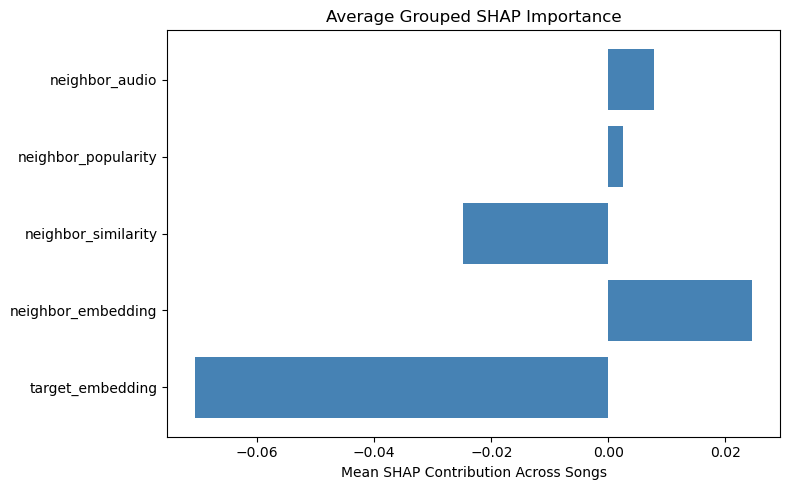

In [66]:
import matplotlib.pyplot as plt

labels = list(avg_shap_importance.keys())
values = [avg_shap_importance[k] for k in labels]

plt.figure(figsize=(8,5))
plt.barh(labels, values, color='steelblue')
plt.xlabel("Mean SHAP Contribution Across Songs")
plt.title("Average Grouped SHAP Importance")
plt.tight_layout()
plt.show()


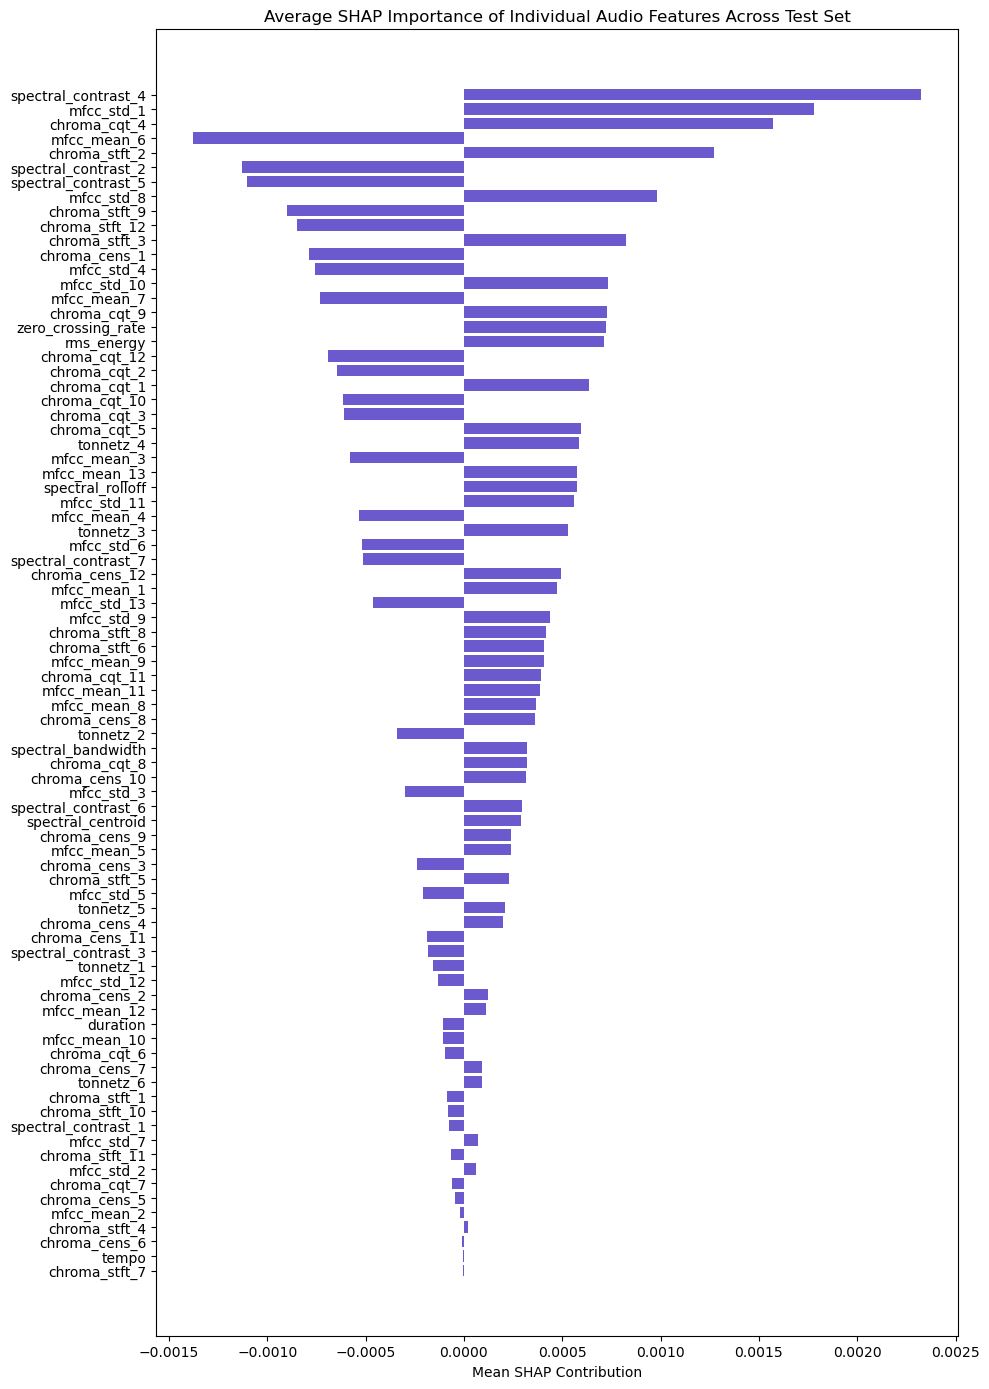

In [67]:
from collections import defaultdict
import numpy as np

# Dictionary where each audio feature name accumulates ALL samples across all neighbors
audio_shap_totals = defaultdict(list)

EMB_DIM = len(df.iloc[0]["lyrics_embedding"])

for i in range(shap_vals_test.shape[0]):
    grouped = group_shap_fully(
        shap_vals_test[i],
        EMB_DIM=EMB_DIM,
        audio_feature_cols=audio_feature_cols,
        k_neighbors=3
    )

    # Loop over all neighbors for this sample
    for nb in grouped["neighbors"]:
        for feat_name, shap_val in nb["audio_features"].items():
            audio_shap_totals[feat_name].append(shap_val)
avg_audio_shap = {
    feat: float(np.mean(vals))
    for feat, vals in audio_shap_totals.items()
}

# Sort by absolute magnitude for a cleaner plot
avg_audio_shap_sorted = dict(
    sorted(avg_audio_shap.items(), key=lambda x: abs(x[1]), reverse=True)
)
import matplotlib.pyplot as plt

features = list(avg_audio_shap_sorted.keys())
values = list(avg_audio_shap_sorted.values())

plt.figure(figsize=(10, 14))
plt.barh(features, values, color='slateblue')
plt.xlabel("Mean SHAP Contribution")
plt.title("Average SHAP Importance of Individual Audio Features Across Test Set")
plt.gca().invert_yaxis()  # Largest magnitude at the top
plt.tight_layout()
plt.show()


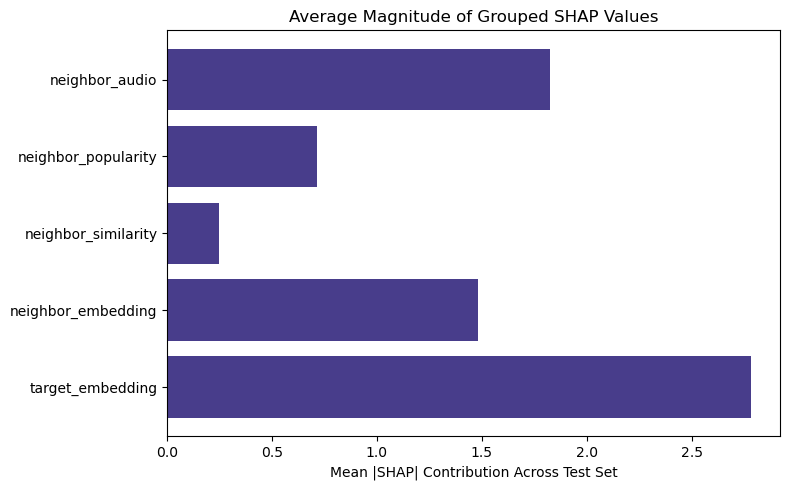

In [68]:
# --- GROUPED SHAP MAGNITUDES ---

EMB_DIM = len(df.iloc[0]["lyrics_embedding"])

# Storage
all_target = []
all_nb_emb = []
all_nb_sim = []
all_nb_pop = []
all_nb_audio = []

for i in range(shap_vals_test.shape[0]):
    grouped = group_shap_fully(
        shap_vals_test[i],
        EMB_DIM=EMB_DIM,
        audio_feature_cols=audio_feature_cols,
        k_neighbors=3
    )

    # target embedding magnitude
    all_target.append(abs(grouped["target_embedding"]))

    # neighbor components
    for nb in grouped["neighbors"]:
        all_nb_emb.append(abs(nb["embedding"]))
        all_nb_sim.append(abs(nb["similarity"]))
        all_nb_pop.append(abs(nb["popularity"]))

        # sum magnitudes of audio features
        audio_mag = sum(abs(v) for v in nb["audio_features"].values())
        all_nb_audio.append(audio_mag)

# Averages
avg_group_mag = {
    "target_embedding": np.mean(all_target),
    "neighbor_embedding": np.mean(all_nb_emb),
    "neighbor_similarity": np.mean(all_nb_sim),
    "neighbor_popularity": np.mean(all_nb_pop),
    "neighbor_audio": np.mean(all_nb_audio),
}

avg_group_mag
import matplotlib.pyplot as plt

labels = list(avg_group_mag.keys())
values = [avg_group_mag[k] for k in labels]

plt.figure(figsize=(8,5))
plt.barh(labels, values, color='darkslateblue')
plt.xlabel("Mean |SHAP| Contribution Across Test Set")
plt.title("Average Magnitude of Grouped SHAP Values")
plt.tight_layout()
plt.show()


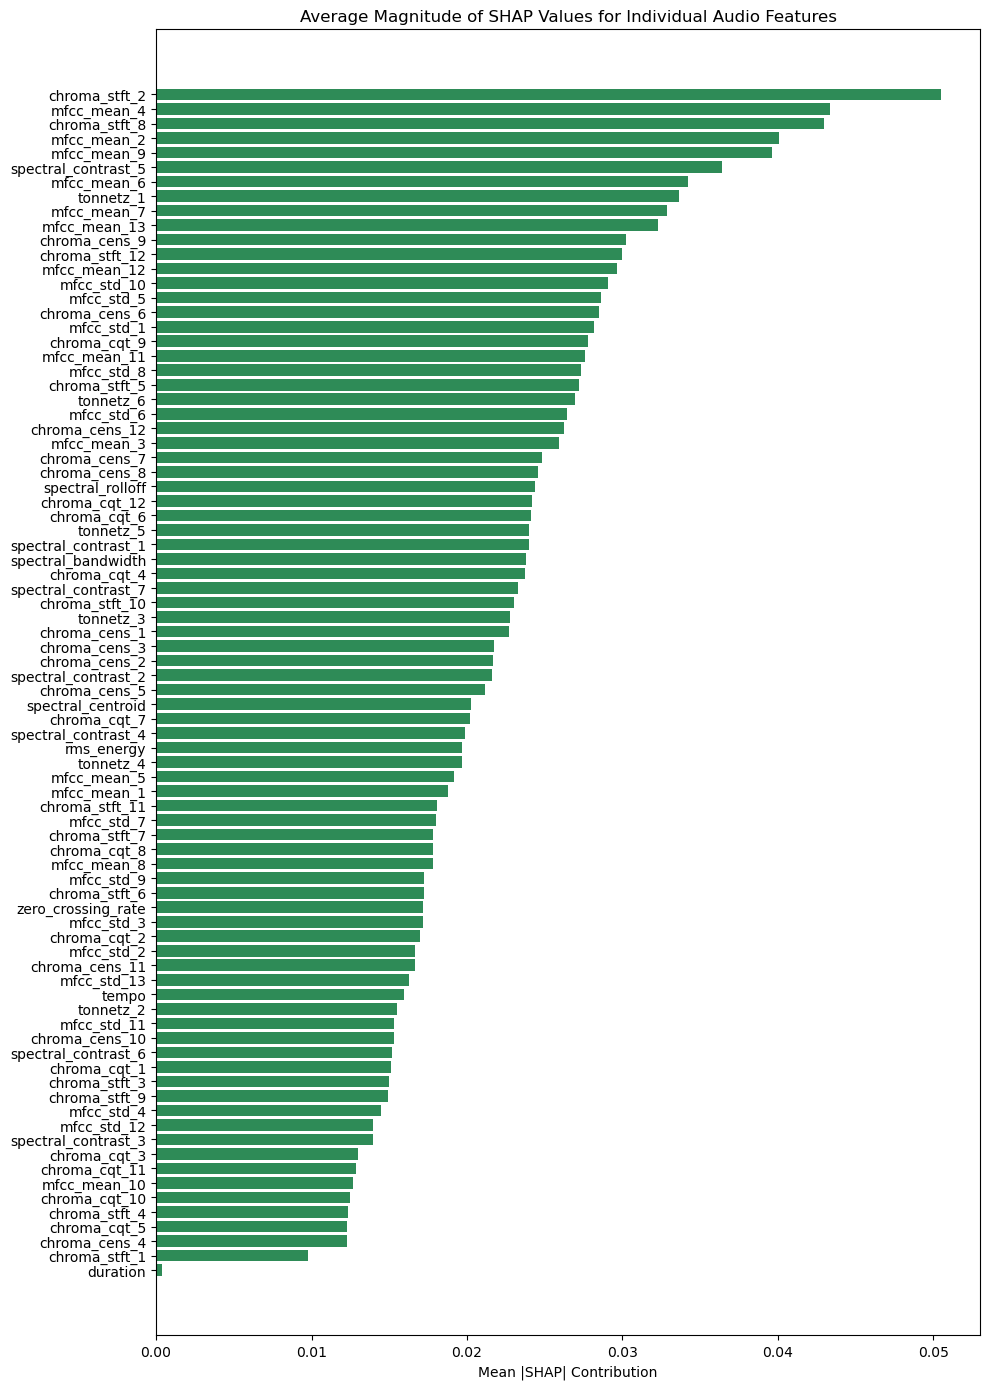

In [69]:
from collections import defaultdict

audio_mag_totals = defaultdict(list)

for i in range(shap_vals_test.shape[0]):
    grouped = group_shap_fully(
        shap_vals_test[i],
        EMB_DIM=EMB_DIM,
        audio_feature_cols=audio_feature_cols,
        k_neighbors=3
    )

    for nb in grouped["neighbors"]:
        for feat_name, shap_val in nb["audio_features"].items():
            audio_mag_totals[feat_name].append(abs(shap_val))
avg_audio_mag = {
    feat: np.mean(vals)
    for feat, vals in audio_mag_totals.items()
}

# Sort by importance
avg_audio_mag_sorted = dict(
    sorted(avg_audio_mag.items(), key=lambda x: x[1], reverse=True)
)
features = list(avg_audio_mag_sorted.keys())
values = list(avg_audio_mag_sorted.values())

plt.figure(figsize=(10, 14))
plt.barh(features, values, color='seagreen')
plt.xlabel("Mean |SHAP| Contribution")
plt.title("Average Magnitude of SHAP Values for Individual Audio Features")
plt.gca().invert_yaxis()  # most important at top
plt.tight_layout()
plt.show()
